In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

In [2]:
datapath = '/scratch/public/mf9078/geo_em_files'

# Load the data
ds1 = xr.open_dataset(f'{datapath}/geo_em.d02.nc_LCZ_g')
ds2 = xr.open_dataset(f'{datapath}/geo_em.d02.nc_WSF3D')
ds3 = xr.open_dataset(f'{datapath}/geo_em.d02.nc_Geoscape')

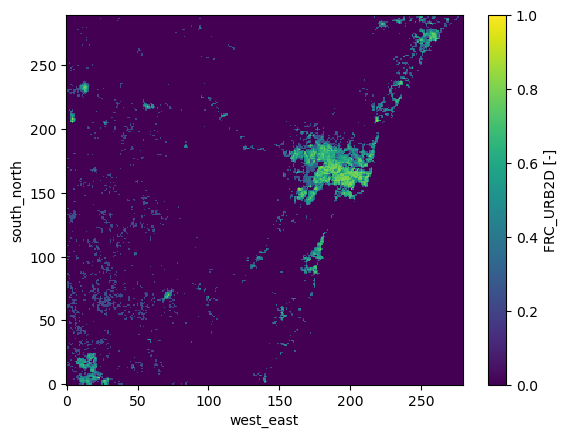

In [3]:
# simplest example! Xarray will automatically define colorbar and titles
ds1['FRC_URB2D'].plot(vmin=0, vmax=1)

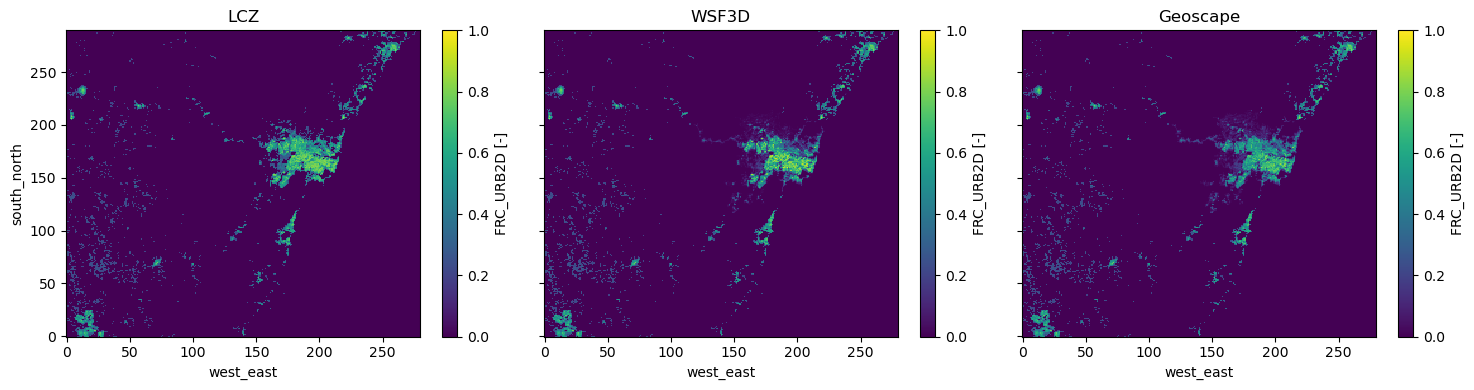

In [4]:
# Slightly more complicated: a subplot with shared axes
# note there are still issues, e.g. coordinates, repeating colorbars and titles
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(15, 4),
    sharex=True,sharey=True,
    )

ds1['FRC_URB2D'].plot(ax=axes[0], vmin=0, vmax=1)
axes[0].set_title('LCZ')

ds2['FRC_URB2D'].plot(ax=axes[1], vmin=0, vmax=1)
axes[1].set_title('WSF3D')
axes[1].set_ylabel('')

ds3['FRC_URB2D'].plot(ax=axes[2], vmin=0, vmax=1)
axes[2].set_title('Geoscape')
axes[2].set_ylabel('')

fig.tight_layout()

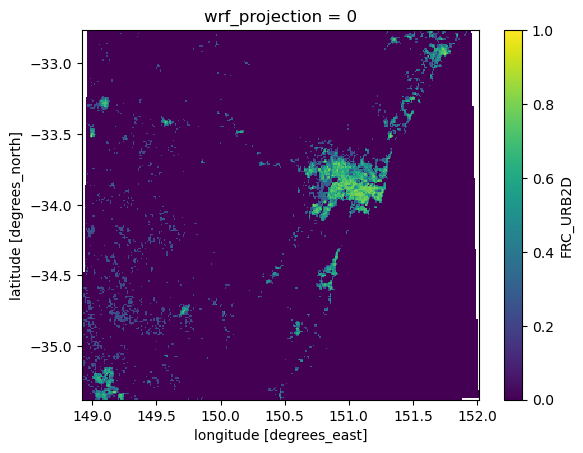

In [5]:
# If you want to fix coordinates to normal lat/lon, you can use xwrf, wrf and rioxarray
import xwrf
import wrf
import rioxarray as rxr

# define a function to reprojects the data onto standard lat/lon
def reproject(ds, key):

    # process the WRF data using xwrf
    ds = ds.xwrf.postprocess(decode_times=False)

    # get the projection information from the processed WRF file
    wkt = ds['wrf_projection'].attrs['crs_wkt']
    da = ds[key].rio.write_crs(wkt)

    # reproject the data to lat/lon with rioxarray
    da = da.rio.reproject('EPSG:4326')

    return da

da1 = reproject(ds1, 'FRC_URB2D')
da2 = reproject(ds2, 'FRC_URB2D')
da3 = reproject(ds3, 'FRC_URB2D')

# now when we plot we get proper lat/lon coordinates
da1.plot(vmin=0, vmax=1)

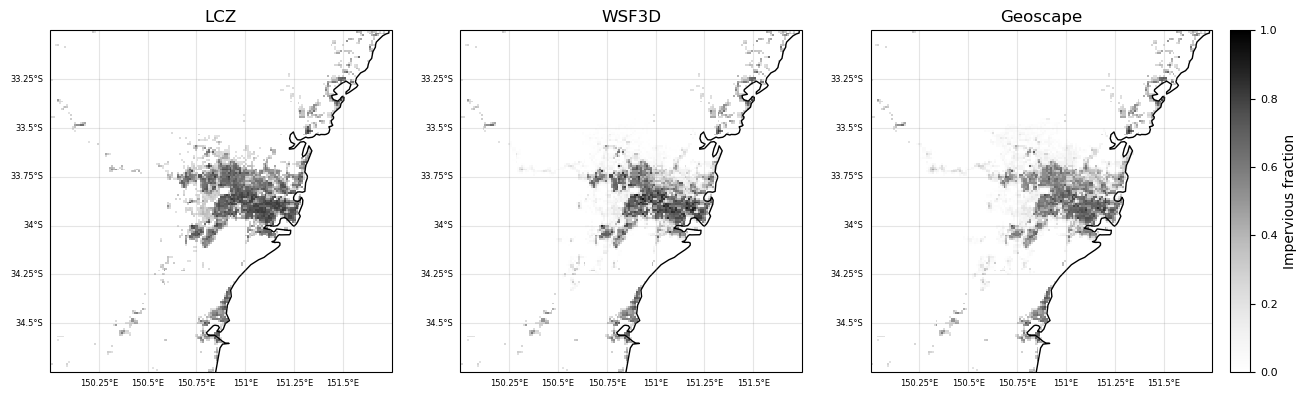

In [9]:
# now, to add plotting with cartopy with single colorbar
# Cartopy ruins some of the xarray plotting features, so we have to more work

# set extent of the data
xmin, xmax = 150, 151.75
ymin, ymax = -34.75, -33

das = [da1, da2, da3]
titles = ['LCZ', 'WSF3D', 'Geoscape']
cbar_title = 'Impervious fraction'

###

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(15, 5),
    sharex=True,sharey=True,
    subplot_kw={'projection': proj},
    )

for ax, da, title in zip(axes.flatten(), das, titles):
    ax.set_extent([xmin, xmax, ymin, ymax], crs=proj)
    
    # note I've turned off the colorbar, I'll add it later by calling the "im" object once
    im = da.plot(ax=ax, transform=proj, cmap='Greys', vmin=0, vmax=1, add_colorbar=False)

    ax.coastlines()

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='0.5', alpha=0.2)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'size': 6}

    ax.set_title(title)

# add a colorbar to last subplot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase

cax = inset_axes(ax,
    width='6%', height='100%', loc='lower left',
    bbox_to_anchor=(1.05, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0,
    )
cbar = ColorbarBase(cax, cmap=im.cmap, norm = im.norm, ticks = None)
cbar.ax.set_ylabel(cbar_title)
cbar.ax.tick_params(labelsize=8)